#### John Peterson (February Cohort) 2-27-18

#### Springboard Data Science Career Track - Capstone Project 1


In [24]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Data file downloaded 02-27-18
# This will be the file used, data is from 11/1/15 to 2/20/18

# Assign filename
data_022718 = 'crime-datacrime-datacrimestat.csv'

# Read file in DataFrame
crime = pd.read_csv(data_022718, sep=',', low_memory=False, dtype={'ZIP': object})

# Quick view of the data
print(crime.head())
print(crime.info())

# Rename columns
crime.columns = ['incident_num', 'date_occurred_on', 'date_occurred_to', 'crime_cat', '100_block_addr', 'zip', 'premise_type']


        INC NUMBER        OCCURRED ON        OCCURRED TO   UCR CRIME CATEGORY  \
0  201600000052855  11/01/2015  00:00  01/09/2016  00:00  MOTOR VEHICLE THEFT   
1  201600000594484  11/01/2015  00:00                NaN                 RAPE   
2  201500002102327  11/01/2015  00:00  11/01/2015  09:00        LARCENY-THEFT   
3  201500002101405  11/01/2015  00:00  11/01/2015  05:00  MOTOR VEHICLE THEFT   
4  201500002102668  11/01/2015  00:00  11/01/2015  11:50  MOTOR VEHICLE THEFT   

             100 BLOCK ADDR    ZIP         PREMISE TYPE  
0  N 43RD AVE & W CACTUS RD  85029  SINGLE FAMILY HOUSE  
1         13XX E ALMERIA RD  85006  SINGLE FAMILY HOUSE  
2            51XX N 15TH ST  85014            APARTMENT  
3       102XX W MEDLOCK AVE  85307  SINGLE FAMILY HOUSE  
4            69XX W WOOD ST  85043  SINGLE FAMILY HOUSE  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148468 entries, 0 to 148467
Data columns (total 7 columns):
INC NUMBER            148468 non-null object
OCCURRED O

## Data Wrangling

In [25]:
# 4 variables have missing data: Occurred On, Occurred To, Zip, Premise Type
print(crime[['date_occurred_on', 'date_occurred_to', 'zip', 'premise_type']].isna().sum())
# 'date_occurred_to' field is blank because the victim knows the exact time the incident occurred and only the 'date_occurred_on' is populated

# Sum number of incidents where occurred_on and occurred_to are NaN
print(crime[(crime.date_occurred_on.isna()) & (crime.date_occurred_to.isna())])


#print(crime.loc[crime['zip'].isna()])
#print(crime.loc[crime['date_occurred_on'].isna()].head())
#print(crime.loc[crime['date_occurred_to'].isna()].head())
#print(crime.loc[crime['premise_type'].isna()].head())

date_occurred_on      336
date_occurred_to    43719
zip                     3
premise_type          805
dtype: int64
Empty DataFrame
Columns: [incident_num, date_occurred_on, date_occurred_to, crime_cat, 100_block_addr, zip, premise_type]
Index: []


In [26]:
# Identify the unique values
print(crime[['crime_cat', 'zip', 'premise_type']].nunique())
#print(crime.crime_cat.unique())
#print(crime.zip.unique())
#print(crime.premise_type.unique())

crime_cat        9
zip             99
premise_type    94
dtype: int64


In [27]:
# Cleaning the data set

# Remove missing zip code rows and convert to str
crime_clean = crime.drop(crime.index[[63037, 79708, 82276]])
print(crime_clean.loc[crime_clean['zip'].isna()])

# Fill in missing date values with date_occurred_on or date_occurred_to
crime_clean.date_occurred_on.fillna(crime_clean.date_occurred_to, inplace=True)
print(crime_clean.iloc[248])
crime_clean.date_occurred_to.fillna(crime_clean.date_occurred_on, inplace=True)
print(crime_clean.iloc[24])
print(crime_clean[['date_occurred_on', 'date_occurred_to']].isna().sum())

# Premise type NaN convert to Unknown
crime_clean.premise_type = crime_clean.premise_type.fillna('UNKNOWN')

# Combine 'STREET / ROADWAY / ALLEY / SIDEWALK' and 'STREET / ROADWAY / ALLEY SIDEWALK'
crime_clean.loc[crime_clean['premise_type'] == 'STREET / ROADWAY / ALLEY SIDEWALK'] = crime_clean.loc[crime_clean['premise_type'] == 'STREET / ROADWAY / ALLEY SIDEWALK'].replace('STREET / ROADWAY / ALLEY SIDEWALK', 'STREET / ROADWAY / ALLEY / SIDEWALK')


Empty DataFrame
Columns: [incident_num, date_occurred_on, date_occurred_to, crime_cat, 100_block_addr, zip, premise_type]
Index: []
incident_num                            201500002110561
date_occurred_on                      11/02/2015  14:40
date_occurred_to                      11/02/2015  14:40
crime_cat                                       ROBBERY
100_block_addr                       41XX W BASELINE RD
zip                                               85041
premise_type        STREET / ROADWAY / ALLEY / SIDEWALK
Name: 248, dtype: object
incident_num                   201500002100158
date_occurred_on             11/01/2015  00:05
date_occurred_to             11/01/2015  00:05
crime_cat                  MOTOR VEHICLE THEFT
100_block_addr             28XX W CAMELBACK RD
zip                                      85017
premise_type        CONVENIENCE MARKET / STORE
Name: 24, dtype: object
date_occurred_on    0
date_occurred_to    0
dtype: int64


In [28]:
# Convert date columns to datetime
crime_clean['date_occurred_on'] = pd.to_datetime(crime_clean['date_occurred_on'], format='%m/%d/%Y %H:%M')
crime_clean['date_occurred_to'] = pd.to_datetime(crime_clean['date_occurred_to'], format='%m/%d/%Y %H:%M')
#crime_clean.info()

# Break down datetime columns into seperate columns, new columns listed below
# date_occ_on ==> [occ_on_month, occ_on_day, occ_on_year, occ_on_hr, occ_on_min]
crime_clean['occ_on_month'] = crime_clean['date_occurred_on'].dt.month
crime_clean['occ_on_day'] = crime_clean['date_occurred_on'].dt.day
crime_clean['occ_on_year'] = crime_clean['date_occurred_on'].dt.year
crime_clean['occ_on_dayofweek'] = crime_clean['date_occurred_on'].dt.weekday_name
crime_clean['occ_on_time'] = crime_clean['date_occurred_on'].dt.time
crime_clean['occ_on_hr'] = crime_clean['date_occurred_on'].dt.hour
crime_clean['occ_on_min'] = crime_clean['date_occurred_on'].dt.minute

# date_occ_to ==> [occ_to_month, occ_to_day, occ_to_year, occ_to_hr, occ_to_min]
crime_clean['occ_to_month'] = crime_clean['date_occurred_to'].dt.month
crime_clean['occ_to_day'] = crime_clean['date_occurred_to'].dt.day
crime_clean['occ_to_year'] = crime_clean['date_occurred_to'].dt.year
crime_clean['occ_to_dayofweek'] = crime_clean['date_occurred_to'].dt.weekday_name
crime_clean['occ_to_time'] = crime_clean['date_occurred_to'].dt.time
crime_clean['occ_to_hr'] = crime_clean['date_occurred_to'].dt.hour
crime_clean['occ_to_min'] = crime_clean['date_occurred_to'].dt.minute

#crime_clean.head()
#crime_clean.info()


In [29]:
# Classify incident times into 4hr bucket groups
# A: 0-3, B: 4-7, C: 8-11, D: 12-15, E: 16-19, F: 20-23
occ_on_hr_grp = []
for row in crime_clean.occ_on_hr:
    if row in [0,1,2,3]:
        occ_on_hr_grp.append('A')
    elif row in [4,5,6,7]:
        occ_on_hr_grp.append('B')
    elif row in [8,9,10,11]:
        occ_on_hr_grp.append('C')
    elif row in [12,13,14,15]:
        occ_on_hr_grp.append('D')
    elif row in [16,17,18,19]:
        occ_on_hr_grp.append('E')
    else: 
        occ_on_hr_grp.append('F')
    
crime_clean['occ_on_hr_grp'] = occ_on_hr_grp


In [30]:
# Classify incident months into seasons
# Spring(3,4,5), Summer(6,7,8), Fall(9,10,11), Winter(12,1,2)
occ_on_season = []
for row in crime_clean.occ_on_month:
    if row in [3,4,5]:
        occ_on_season.append('Spring')
    elif row in [6,7,8]:
        occ_on_season.append('Summer')
    elif row in [9,10,11]:
        occ_on_season.append('Fall')
    else:
        occ_on_season.append('Winter')
        
crime_clean['occ_on_season'] = occ_on_season

# crime_clean is the clean data set

## Exploratory Data Analysis

**Initial Questions**

 1. What are the top tredning crimes?
 2. When do crimes occur: Month, Day, Year, Season?
 3. Do more crimes occur in certain zip codes?
 4. What is the most common place a crime occurs e.g. house, business, etc.?

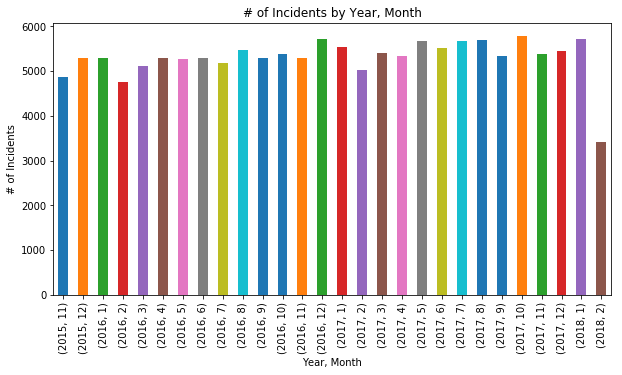

In [31]:
# Number of incidents per month by year
inc_mon_yr = crime_clean.groupby(['occ_on_year', 'occ_on_month'])['incident_num'].count()
inc_mon_yr
inc_mon_yr.plot(kind='bar', figsize=(10,5))
plt.ylabel('# of Incidents')
plt.xlabel('Year, Month')
plt.title('# of Incidents by Year, Month')
plt.show()

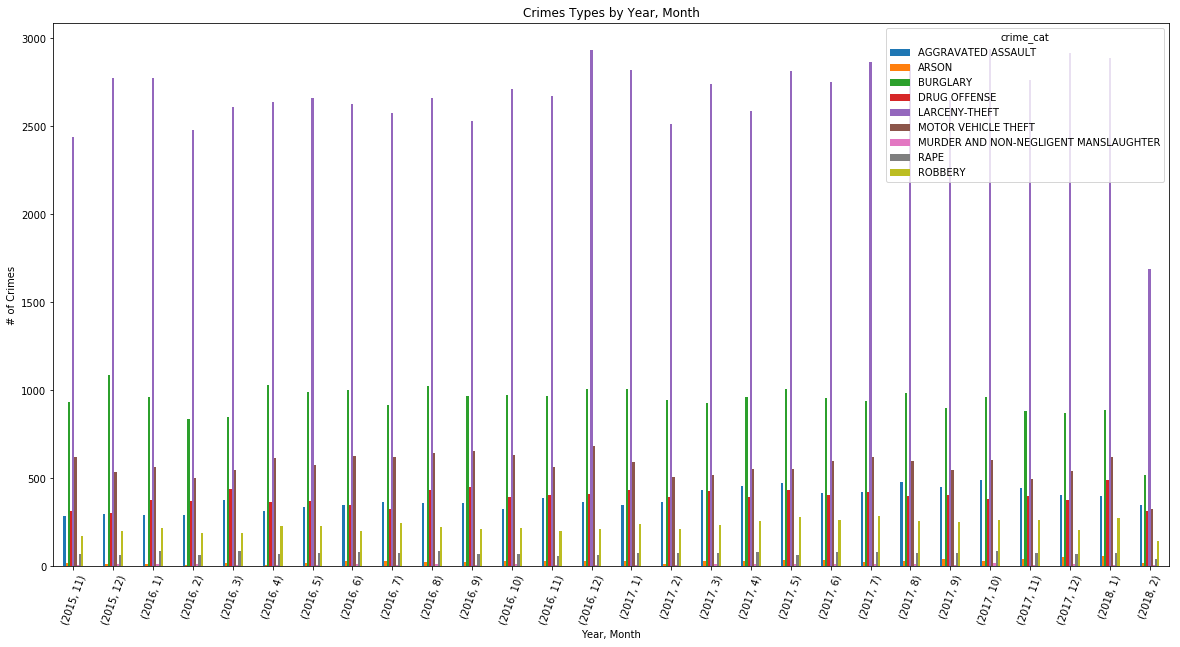

In [32]:
# Number of types of crime per month by year
crime_month = crime_clean.groupby(['occ_on_year','occ_on_month','crime_cat'])['crime_cat'].count()
crime_month.unstack().plot(kind='bar', figsize=(20,10), rot=70)
plt.title('Crimes Types by Year, Month')
plt.xlabel('Year, Month')
plt.ylabel('# of Crimes')
plt.show()

occ_on_dayofweek
Friday       22600
Wednesday    21864
Tuesday      21774
Thursday     21615
Monday       21217
Saturday     20468
Sunday       18927
Name: incident_num, dtype: int64


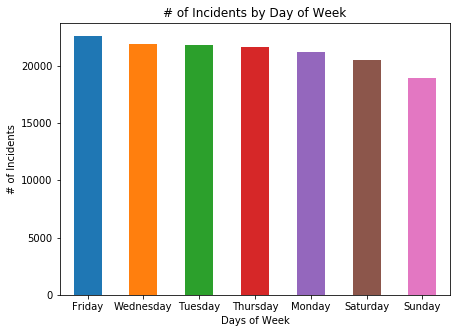

In [33]:
# Day of the week crimes take place
crime_dayofweek = crime_clean.groupby('occ_on_dayofweek')['incident_num'].count().sort_values(ascending=False)
print(crime_dayofweek)
crime_dayofweek.plot(kind='bar', figsize=(7,5), rot=0)
plt.title('# of Incidents by Day of Week')
plt.ylabel('# of Incidents')
plt.xlabel('Days of Week')
plt.show()

occ_on_hr_grp
E    33717
D    29432
F    29193
C    22367
A    20489
B    13267
Name: incident_num, dtype: int64


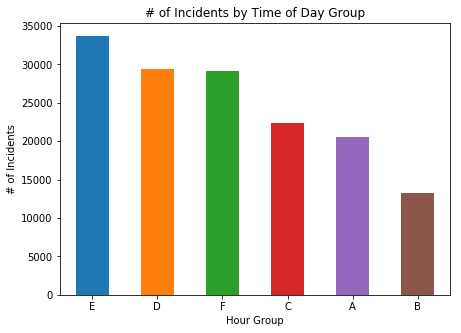

In [34]:
# Time of Day crimes occur
# A: 0-3, B: 4-7, C: 8-11, D: 12-15, E: 16-19, F: 20-23
crime_timeofday = crime_clean.groupby('occ_on_hr_grp')['incident_num'].count().sort_values(ascending=False)
print(crime_timeofday[:10])
crime_timeofday.plot(kind='bar', figsize=(7,5), rot=0,)
plt.title('# of Incidents by Time of Day Group')
plt.xlabel('Hour Group')
plt.ylabel('# of Incidents')
plt.show()

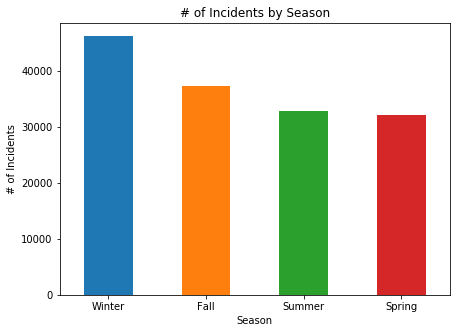

In [35]:
# Time of year most crimes occurred
season_inc = crime_clean.groupby('occ_on_season')['incident_num'].count().sort_values(ascending=False)
season_inc
season_inc.plot(kind='bar', figsize=(7,5), rot=0)
plt.title('# of Incidents by Season')
plt.xlabel('Season')
plt.ylabel('# of Incidents')
plt.show()

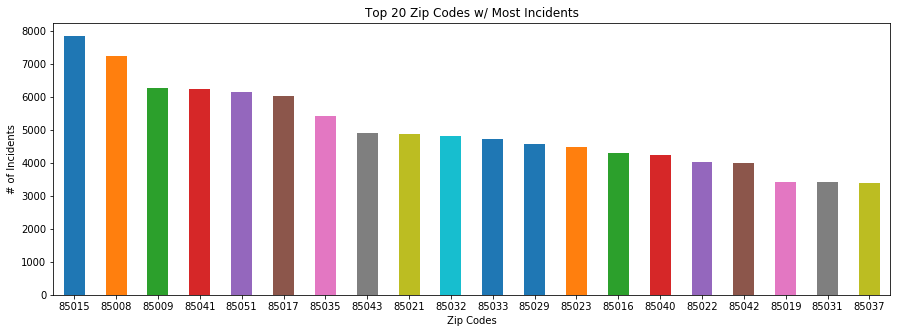

In [36]:
# Crimes by zip code
zip_inc = crime_clean.groupby('zip')['incident_num'].count().sort_values(ascending=False)
zip_inc
zip_inc[0:20].plot(kind='bar', figsize=(15,5), rot=0)
plt.title('Top 20 Zip Codes w/ Most Incidents')
plt.xlabel('Zip Codes')
plt.ylabel('# of Incidents')
plt.show()

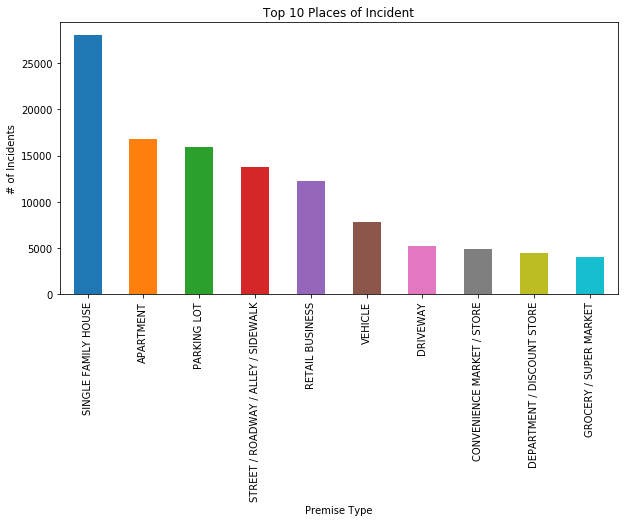

In [37]:
# Most common place a crime takes place
premise_count = crime_clean.groupby('premise_type')['incident_num'].count().sort_values(ascending=False)
premise_count
premise_count[0:10].plot(kind='bar', figsize=(10,5))
plt.title('Top 10 Places of Incident')
plt.xlabel('Premise Type')
plt.ylabel('# of Incidents')
plt.show()

**Market Basket Analysis**

In [38]:
# Create basket df
basket = crime_clean[['crime_cat', 'zip', 'premise_type', 'occ_on_month', 'occ_on_day', 'occ_on_year', 'occ_on_hr_grp', 'occ_on_dayofweek', 'occ_on_season']]
basket = pd.DataFrame(basket)
basket.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148465 entries, 0 to 148467
Data columns (total 9 columns):
crime_cat           148465 non-null object
zip                 148465 non-null object
premise_type        148465 non-null object
occ_on_month        148465 non-null int64
occ_on_day          148465 non-null int64
occ_on_year         148465 non-null int64
occ_on_hr_grp       148465 non-null object
occ_on_dayofweek    148465 non-null object
occ_on_season       148465 non-null object
dtypes: int64(3), object(6)
memory usage: 11.3+ MB


In [39]:
# change int to string
basket['occ_on_month'] = basket['occ_on_month'].astype(str)
basket['occ_on_day'] = basket['occ_on_day'].astype(str)
basket['occ_on_year'] = basket['occ_on_year'].astype(str)

In [40]:
# change month number to string (e.g Jan, Feb, etc.)
basket.loc[basket['occ_on_month'] == '1'] = basket.loc[basket['occ_on_month'] == '1'].replace('1', 'Jan')
basket.loc[basket['occ_on_month'] == '2'] = basket.loc[basket['occ_on_month'] == '2'].replace('2', 'Feb')
basket.loc[basket['occ_on_month'] == '3'] = basket.loc[basket['occ_on_month'] == '3'].replace('3', 'Mar')
basket.loc[basket['occ_on_month'] == '4'] = basket.loc[basket['occ_on_month'] == '4'].replace('4', 'Apr')
basket.loc[basket['occ_on_month'] == '5'] = basket.loc[basket['occ_on_month'] == '5'].replace('5', 'May')
basket.loc[basket['occ_on_month'] == '6'] = basket.loc[basket['occ_on_month'] == '6'].replace('6', 'Jun')
basket.loc[basket['occ_on_month'] == '7'] = basket.loc[basket['occ_on_month'] == '7'].replace('7', 'Jul')
basket.loc[basket['occ_on_month'] == '8'] = basket.loc[basket['occ_on_month'] == '8'].replace('8', 'Aug')
basket.loc[basket['occ_on_month'] == '9'] = basket.loc[basket['occ_on_month'] == '9'].replace('9', 'Sep')
basket.loc[basket['occ_on_month'] == '10'] = basket.loc[basket['occ_on_month'] == '10'].replace('10', 'Oct')
basket.loc[basket['occ_on_month'] == '11'] = basket.loc[basket['occ_on_month'] == '11'].replace('11', 'Nov')
basket.loc[basket['occ_on_month'] == '12'] = basket.loc[basket['occ_on_month'] == '12'].replace('12', 'Dec')

In [41]:
# create different baskets with different items

# basket 1: crime cat, zip
basket_1 = np.array(basket[['crime_cat', 'zip']])

# basket 2: crime cat, time of day, day of the week
basket_2 = np.array(basket[['crime_cat', 'occ_on_hr_grp', 'occ_on_dayofweek']])

# basket 3: crime_cat, month, day, year
basket_3 = np.array(basket[['crime_cat', 'occ_on_month', 'occ_on_day', 'occ_on_year']])

# basket 4: crime cat, season
basket_4 = np.array(basket[['crime_cat', 'occ_on_season']])

# basket 5: crime cat, zip, premise type
basket_5 = np.array(basket[['crime_cat', 'zip', 'premise_type']])


In [42]:
# train apriori model
from apyori import apriori

rules_1 = apriori(basket_1, min_support=0.05, min_confidence=0.2)
rules_2 = apriori(basket_2, min_support=0.05, min_confidence=0.2)
rules_3 = apriori(basket_3, min_support=0.05, min_confidence=0.2)
rules_4 = apriori(basket_4, min_support=0.05, min_confidence=0.2)
rules_5 = apriori(basket_5, min_support=0.003, min_confidence=0.2, min_length=3)

In [43]:
# results rules 1
results_1 = list(rules_1)
results_1

[RelationRecord(items=frozenset({'LARCENY-THEFT'}), support=0.5043815040581955, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'LARCENY-THEFT'}), confidence=0.5043815040581955, lift=1.0)])]

In [44]:
# results rules 2
results_2 = list(rules_2)
results_2

[RelationRecord(items=frozenset({'E'}), support=0.2271040312531573, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'E'}), confidence=0.2271040312531573, lift=1.0)]),
 RelationRecord(items=frozenset({'LARCENY-THEFT'}), support=0.5043815040581955, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'LARCENY-THEFT'}), confidence=0.5043815040581955, lift=1.0)]),
 RelationRecord(items=frozenset({'LARCENY-THEFT', 'A'}), support=0.06095039234836493, ordered_statistics=[OrderedStatistic(items_base=frozenset({'A'}), items_add=frozenset({'LARCENY-THEFT'}), confidence=0.4416516179413344, lift=0.8756300823639573)]),
 RelationRecord(items=frozenset({'LARCENY-THEFT', 'C'}), support=0.07337756373556056, ordered_statistics=[OrderedStatistic(items_base=frozenset({'C'}), items_add=frozenset({'LARCENY-THEFT'}), confidence=0.48705682478651574, lift=0.9656516364452555)]),
 RelationRecord(items=frozenset({'D', 'LARCENY-THEFT'}), support=0.1132

In [45]:
# results rules 3
results_3 = list(rules_3)
results_3

[RelationRecord(items=frozenset({'2016'}), support=0.42664601084430676, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'2016'}), confidence=0.42664601084430676, lift=1.0)]),
 RelationRecord(items=frozenset({'2017'}), support=0.4434984676523086, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'2017'}), confidence=0.4434984676523086, lift=1.0)]),
 RelationRecord(items=frozenset({'LARCENY-THEFT'}), support=0.5043815040581955, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'LARCENY-THEFT'}), confidence=0.5043815040581955, lift=1.0)]),
 RelationRecord(items=frozenset({'BURGLARY', '2016'}), support=0.07762772370592395, ordered_statistics=[OrderedStatistic(items_base=frozenset({'BURGLARY'}), items_add=frozenset({'2016'}), confidence=0.4384296420283791, lift=1.027619222691789)]),
 RelationRecord(items=frozenset({'LARCENY-THEFT', '2016'}), support=0.2147846293739265, ordered_statistics=[Order

In [46]:
# results rules 4
results_4 = list(rules_4)
results_4

[RelationRecord(items=frozenset({'Fall'}), support=0.2513723773279898, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Fall'}), confidence=0.2513723773279898, lift=1.0)]),
 RelationRecord(items=frozenset({'LARCENY-THEFT'}), support=0.5043815040581955, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'LARCENY-THEFT'}), confidence=0.5043815040581955, lift=1.0)]),
 RelationRecord(items=frozenset({'Spring'}), support=0.21623278213720407, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Spring'}), confidence=0.21623278213720407, lift=1.0)]),
 RelationRecord(items=frozenset({'Summer'}), support=0.22105546761863065, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Summer'}), confidence=0.22105546761863065, lift=1.0)]),
 RelationRecord(items=frozenset({'Winter'}), support=0.3113393729161755, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_ad

In [47]:
# results rules  5
results_5 = list(rules_5)
results_5

[RelationRecord(items=frozenset({'LARCENY-THEFT'}), support=0.5043815040581955, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'LARCENY-THEFT'}), confidence=0.5043815040581955, lift=1.0)]),
 RelationRecord(items=frozenset({'LARCENY-THEFT', '85003'}), support=0.005772404270366753, ordered_statistics=[OrderedStatistic(items_base=frozenset({'85003'}), items_add=frozenset({'LARCENY-THEFT'}), confidence=0.5026392961876833, lift=0.9965458529773702)]),
 RelationRecord(items=frozenset({'85004', 'LARCENY-THEFT'}), support=0.007570807934530024, ordered_statistics=[OrderedStatistic(items_base=frozenset({'85004'}), items_add=frozenset({'LARCENY-THEFT'}), confidence=0.6059299191374664, lift=1.201332551376734)]),
 RelationRecord(items=frozenset({'LARCENY-THEFT', '85006'}), support=0.0091132590172768, ordered_statistics=[OrderedStatistic(items_base=frozenset({'85006'}), items_add=frozenset({'LARCENY-THEFT'}), confidence=0.4505494505494506, lift=0.8932711586852048)])

**Inferential Statistics**

In [48]:
import scipy.stats as stats

# describe the basket
basket.describe()

,crime_cat,zip,premise_type,occ_on_month,occ_on_day,occ_on_year,occ_on_hr_grp,occ_on_dayofweek,occ_on_season
count,148465,148465,148465,148465,148465,148465,148465,148465,148465
unique,9,99,93,12,43,4,6,7,4
top,LARCENY-THEFT,85015,SINGLE FAMILY HOUSE,Jan,1,2017,E,Friday,Winter
freq,74883,7839,28011,16565,5177,65844,33717,22600,46223


**1. Compare Crime Category with Zip Code**

  * **Null Hypothesis:** There is no association between the crime type and zip code.
  * **Alternate Hypothesis:** There is an association between the crime type and zip code.

In [49]:
# use contingency table and chi-square to test association
con_table = pd.crosstab(index=basket.crime_cat, columns=basket.zip)
con_table

zip,85003,85004,85006,85007,85008,85009,85012,85013,85014,85015,...,85345,85353,85355,85363,85381,85382,85383,85392,85395,85396
crime_cat,,,,,,,,,,,,,,,,,,,,,
AGGRAVATED ASSAULT,139,138,281,276,592,559,47,181,162,539,...,0,122,0,0,0,0,1,2,1,0
ARSON,8,4,27,25,60,28,3,10,11,59,...,0,6,0,0,0,0,0,0,0,0
BURGLARY,205,167,527,331,1059,1056,166,546,528,1257,...,0,365,0,0,0,0,1,0,0,1
DRUG OFFENSE,223,126,220,320,560,748,78,223,163,661,...,4,35,1,0,1,0,1,7,0,1
LARCENY-THEFT,857,1124,1353,857,3665,2444,527,1809,1314,4125,...,0,667,0,0,0,1,0,0,0,3
MOTOR VEHICLE THEFT,134,146,322,197,843,981,61,250,206,638,...,1,216,0,0,0,1,1,0,0,4
MURDER AND NON-NEGLIGENT MANSLAUGHTER,1,5,15,14,19,15,2,1,7,22,...,0,6,0,0,0,0,0,0,0,0
RAPE,48,40,88,72,108,84,17,62,60,86,...,1,14,0,1,0,0,0,0,1,0
ROBBERY,90,105,170,143,314,349,40,148,97,452,...,1,62,0,0,0,0,0,0,0,1


In [66]:
# contingecy table with percentages
con_table_percent = pd.crosstab(index=basket.crime_cat, columns=basket.zip).apply(lambda r: (r/r.sum())*100, axis=1)
#con_table_percent

In [51]:
# chi square test
chi2, p, dof, ex =stats.chi2_contingency(con_table)
print(('Chi-Square:', chi2),('p-value:', p))


('Chi-Square:', 8401.536479555802) ('p-value:', 0.0)


The p-value is 0 therefore the null hypothesis is rejected which indicates there is an association between crime type and the zip code.

**2. Compare Crime Category with Time Crime Occurred**

  * **Null Hypothesis:** There is no association between the crime type and time of day crime occurred.
  * **Alternate Hypothesis:** There is an association between crime type and time of day crime occurred.

In [52]:
# contignecy table crime type and time of day
con_table_1 = pd.crosstab(index=basket.crime_cat, columns=basket.occ_on_hr_grp)
con_table_1

occ_on_hr_grp,A,B,C,D,E,F
crime_cat,,,,,,
AGGRAVATED ASSAULT,1879,749,1167,1845,2506,2506
ARSON,159,106,120,114,141,147
BURGLARY,3407,4029,5602,4964,4881,3404
DRUG OFFENSE,1529,766,1686,2110,2736,2162
LARCENY-THEFT,9049,5144,10894,16814,18719,14263
MOTOR VEHICLE THEFT,2506,1718,2029,2242,3046,4537
MURDER AND NON-NEGLIGENT MANSLAUGHTER,90,37,23,40,52,78
RAPE,697,139,187,264,330,462
ROBBERY,1173,579,659,1039,1306,1634


In [67]:
# contingency table with percentages
con_table_percent_1 = pd.crosstab(index=basket.crime_cat, columns=basket.occ_on_hr_grp).apply(lambda r: (r/r.sum())*100, axis=1)
#con_table_percent_1

In [116]:
# chi square test
chi2, p, dof, ex =stats.chi2_contingency(con_table_1)
print(('Chi-Square:', chi2),('p-value:', p))


('Chi-Square:', 6545.711432337271) ('p-value:', 0.0)


The p-value is 0 therefore the null hypothesis is rejected which indicates there is an association between crime type and time of day crime occurred.

**3. Compare Crime Category with Season of the year**

  * **Null Hypothesis:** There is no association between crime type and season of the year
  * **Alternate Hypothesis** There is an association between crime type and season of the year.

In [117]:
# contignecy table crime type and season
con_table_2 = pd.crosstab(index=basket.crime_cat, columns=basket.occ_on_season)
con_table_2

occ_on_season,Fall,Spring,Summer,Winter
crime_cat,,,,
AGGRAVATED ASSAULT,2752,2395,2395,3110
ARSON,211,146,183,247
BURGLARY,6583,5768,5821,8115
DRUG OFFENSE,2758,2427,2330,3474
LARCENY-THEFT,18709,16054,16333,23787
MOTOR VEHICLE THEFT,4124,3365,3713,4876
MURDER AND NON-NEGLIGENT MANSLAUGHTER,82,66,79,93
RAPE,517,456,485,621
ROBBERY,1584,1426,1480,1900


In [68]:
# contingency table with percentages
con_table_percent_2 = pd.crosstab(index=basket.crime_cat, columns=basket.occ_on_season).apply(lambda r: (r/r.sum())*100, axis=1)
#con_table_percent_2

In [119]:
# chi square test
chi2, p, dof, ex =stats.chi2_contingency(con_table_2)
print(('Chi-Square:', chi2),('p-value:', p))


('Chi-Square:', 75.24371449549231) ('p-value:', 3.4184825183899065e-07)


The p-value is very low approaching 0 and under the 0.05 threshold therefore the null hypothesis is rejected indicating there is an association between crime type and season of the year.

**4. Compare Crime Category with Month**

  * **Null Hypothesis:** There is no association between crime type and premise type.
  * **Alternate Hypothesis** There is an association between crime type and premise type.

In [120]:
# contignecy table crime type and month
con_table_3 = pd.crosstab(index=basket.crime_cat, columns=basket.occ_on_month)
con_table_3

occ_on_month,1,10,11,12,2,3,4,5,6,7,8,9
crime_cat,,,,,,,,,,,,
AGGRAVATED ASSAULT,1041,817,1121,1063,1006,808,775,812,764,788,843,814
ARSON,106,57,88,104,37,49,42,55,72,57,54,66
BURGLARY,2860,1935,2784,2959,2296,1777,1998,1993,1958,1854,2009,1864
DRUG OFFENSE,1302,781,1117,1091,1081,868,755,804,753,746,831,860
LARCENY-THEFT,8481,5655,7873,8627,6679,5349,5227,5478,5380,5442,5511,5181
MOTOR VEHICLE THEFT,1779,1237,1687,1763,1334,1067,1169,1129,1224,1246,1243,1200
MURDER AND NON-NEGLIGENT MANSLAUGHTER,29,34,29,36,28,24,21,21,29,24,26,19
RAPE,235,162,207,202,184,163,152,141,161,159,165,148
ROBBERY,732,483,637,622,546,427,487,512,466,532,482,464


In [69]:
# contingency table with percentages
con_table_percent_3 = pd.crosstab(index=basket.crime_cat, columns=basket.occ_on_month).apply(lambda r: (r/r.sum())*100, axis=1)
#con_table_percent_3

In [122]:
# chi square test
chi2, p, dof, ex =stats.chi2_contingency(con_table_3)
print(('Chi-Square:', chi2),('p-value:', p))


('Chi-Square:', 257.4293942865455) ('p-value:', 1.6102836646351823e-18)


The p-value is very low approaching 0 and under the 0.05 threshold therefore the null hypothesis is rejected indicating there is an association between crime type and month of the year.

**5. Compare Crime Category with Premise Type**

  * **Null Hypothesis:** There is no association between crime type and premise type.
  * **Alternate Hypothesis** There is an association between crime type and premise type.

In [28]:
# contignecy table crime type and premise type
con_table_4 = pd.crosstab(index=basket.crime_cat, columns=basket.premise_type)
con_table_4

premise_type,07A STOREROOM/SHED (COMMERCIAL),07A STOREROOM/SHED (RESIDENTIAL),ABANDONED/CONDEMNED STRUCTURE,ADULT ONLY STORE / MOVIE,AIRPORT,AMUSEMENT PARK,APARTMENT,ARENA / STADIUM / CONVENTION CENTER,ATM SEPARATE FROM BANK,AUTO DEALERSHIP NEW/USED,...,SINGLE FAMILY HOUSING,SPECIALTY STORE,STOREROOM / SHED,STREET / ROADWAY / ALLEY / SIDEWALK,THEATRE,TRAIN STATION,TRIBAL LANDS,UNKNOWN,VEHICLE,WAREHOUSE / FACTORY
crime_cat,,,,,,,,,,,,,,,,,,,,,
AGGRAVATED ASSAULT,0,1,4,5,22,0,2505,7,0,2,...,0,23,0,2373,3,2,0,143,261,10
ARSON,0,0,1,0,0,0,55,0,0,0,...,0,2,0,43,0,0,0,315,32,1
BURGLARY,289,193,2,8,37,2,4366,6,1,14,...,2,237,0,22,5,4,0,67,124,164
DRUG OFFENSE,5,0,2,4,93,0,632,3,0,1,...,0,42,0,3161,3,1,0,74,1634,15
LARCENY-THEFT,38,25,3,36,545,10,6174,60,5,40,...,1245,997,4,3596,27,15,1,711,4917,202
MOTOR VEHICLE THEFT,2,1,1,5,15,3,2112,6,0,43,...,0,35,0,2722,2,0,0,192,360,21
MURDER AND NON-NEGLIGENT MANSLAUGHTER,0,0,0,0,0,0,48,0,0,0,...,0,0,0,61,0,0,0,18,9,0
RAPE,0,1,2,2,2,0,551,0,0,0,...,0,1,0,133,0,0,0,143,134,0
ROBBERY,1,0,0,8,2,0,370,0,7,2,...,0,205,0,1622,1,3,0,23,304,2


In [70]:
# contingency table with percentages
con_table_percent_4 = pd.crosstab(index=basket.crime_cat, columns=basket.premise_type).apply(lambda r: (r/r.sum())*100, axis=1)
#con_table_percent_4

In [30]:
# chi square test
chi2, p, dof, ex =stats.chi2_contingency(con_table_4)
print(('Chi-Square:', chi2),('p-value:', p))

('Chi-Square:', 100755.37314596443) ('p-value:', 0.0)


The p-value is 0 therefore the null hypothesis is rejected which indicates there is an association between crime type and premise type.

****

**EDA and Inferential Statistics Summary**

The crime data set is categorical type data set. The graphs created show counts of the groups within each variable based on different filters. To draw insights from the data using visualizations some initial questions were asked:

  1. What are the top trending crimes? 
  2. When do crimes occur: Month, Day, Year, Season?
  3. Do more crimes occur in certain zip codes?
  4. What is the most common place a crime occurs e.g. house, business, etc.?
  
**Answers:**
  * Top trending crimes are Larceny-Theft, Burglary, Motor Vehicle Theft, Drug Offenses
  * The most crimes occurred in the Winter months(Dec, Jan, Feb), Fridays and between the hours of 4-7pm.
  * Two zip codes stood out with the most crimes 85015 and 85008.
  * Crimes typically took place at Single Family Homes, Apartments, and Parking Lots.
  
These answers provide us with good information to look at how these categories are related. A technique to help identify relationships or associations is Market Basket Analysis (MBA). MBA takes the data and determines what items are commonly associated e.g. people who purchase Milk & Bread also purchase cheese. To accomplish this we use the Apriori function from the Apyori library. The main outputs of the Apriori function are the **Frequent itemsets** and **Support metric**. **Frequent itemsets** are the item or sets of items most frequently occurring together and the **Support metric** is the fraction of transactions where item(s) occur divided by the total number transactions. The higher the support the more frequently the item(s) occur. Along with frequent itemsets and the support metric there are 2 additional key metrics **Confidence** and **Lift** which are known as Association rules. **Confidence** is the probability of seeing an itemset that contains an item of the itemset. **Lift** is used to measure how more often an itemset occurs than we would expect if the items in the itemset were statistically independent. A Lift score of of 1 indicates independence.

Using the Apriori function with the following minimums: min_support=0.003, min_confidence=0.2, min_lift=4, min_length=4, a list of itemsets with support, confidence and lift were returned. The low Support and Confidence minimums were used to return more itemsets. The large Lift score was used to find itemsets that were far from independent. Reviewing the results showed the more items in the itemset the smaller the support and lower confidence which is expected. Single item and 2 item itemsets returned larger support and confidence values. The itemsets returned showed some patterns of items containing: Year, Month, Crime, Premise type, Time range and Season. What was not returned was itemsets containing zip codes, crimes, premise type, month, season, time range. The MBA was useful in returning frequent itemsets confirming suspected combinations. 

To further test the answers from the visualizations and MBA we can use Inferential Statistics. Inferential Statistics let us draw conclusions and predict outcomes. Based on the information from visualizations and MBA, hypotheses were written and tested on a set of sample data. The Chi-Square test statistic was used because we want to test the strength of association between variables. 

**1. Compare Crime Category with Zip Code**
  
  * **Null Hypothesis:** There is no association between the crime type and zip code.
  * **Alternate Hypothesis:** There is an association between the crime type and zip code.
  * **Answer:** P-value = 0.0, null hypothesis is rejected
  
**2. Compare Crime Category with Time Crime Occurred**
  
  * **Null Hypothesis:** There is no association between the crime type and time of day crime occurred.
  * **Alternate Hypothesis:** There is an association between crime type and time of day crime occurred.
  * **Answer:** P-value = 0.0, null hypothesis is rejected
  
**3. Compare Crime Category with Season of the year**
  
  * **Null Hypothesis:** There is no association between crime type and season of the year.
  * **Alternate Hypothesis** There is an association between crime type and season of the year.
  * **Answer:** P-value = 3.4184825183899065e-07, null hypothesis is rejected
  
**4. Compare Crime Category with Month**

  * **Null Hypothesis:** There is no association between crime type and premise type.
  * **Alternate Hypothesis** There is an association between crime type and premise type.
  * **Answer:** P-value = 1.6102836646351823e-18, null hypothesis is rejected
  
**5. Compare Crime Category with Premise Type**

  * **Null Hypothesis:** There is no association between crime type and premise type.
  * **Alternate Hypothesis** There is an association between crime type and premise type.
  * **Answer:** P-value = 0.0, null hypothesis is rejected
  
From the hypothesis testing we see that Crime Type has significant associations with Zip Code, Time Crime Occurred, Premise Type, Season of the year and Months. 

****

## Machine Engineering

**Feature Engineering**

In [77]:
# feature engineering data frame
feat_eng = basket
feat_eng.describe()

,crime_cat,zip,premise_type,occ_on_month,occ_on_day,occ_on_year,occ_on_hr_grp,occ_on_dayofweek,occ_on_season
count,148465,148465,148465,148465,148465,148465,148465,148465,148465
unique,9,99,93,12,43,4,6,7,4
top,LARCENY-THEFT,85015,SINGLE FAMILY HOUSE,Jan,1,2017,E,Friday,Winter
freq,74883,7839,28011,16565,5177,65844,33717,22600,46223


In [99]:
# total crimes by crime type per zip code
zip_crime_feat = feat_eng.groupby(['zip', 'crime_cat'])[['crime_cat']].count().unstack()
zip_crime_feat

crime_cat                                            \
crime_cat AGGRAVATED ASSAULT ARSON BURGLARY DRUG OFFENSE LARCENY-THEFT   
zip                                                                      
85003                  139.0   8.0    205.0        223.0         857.0   
85004                  138.0   4.0    167.0        126.0        1124.0   
85006                  281.0  27.0    527.0        220.0        1353.0   
85007                  276.0  25.0    331.0        320.0         857.0   
85008                  592.0  60.0   1059.0        560.0        3665.0   
85009                  559.0  28.0   1056.0        748.0        2444.0   
85012                   47.0   3.0    166.0         78.0         527.0   
85013                  181.0  10.0    546.0        223.0        1809.0   
85014                  162.0  11.0    528.0        163.0        1314.0   
85015                  539.0  59.0   1257.0        661.0        4125.0   
85016                  202.0  21.0    711.0        257.0        2538.0   
85017                  544.0  24.0    922.0        698.0        2604.0   
85018                  183.0  13.0    695.0        200.0        1521.0   
85019                  282.0  22.0    863.0        288.0        1229.0   
85020                  245.0  23.0    634.0        190.0        1671.0   
85021                  391.0  22.0    832.0        494.0        2376.0   
85022                  255.0  15.0    624.0        220.0        2397.0   
85023                  216.0  16.0    558.0        489.0        2681.0   
85024                   48.0   6.0    227.0         66.0         564.0   
85027                  178.0  15.0    465.0        242.0        1900.0   
85028                   33.0   9.0    226.0         28.0         472.0   
85029                  312.0  21.0    797.0        386.0        2341.0   
85031                  281.0  19.0    563.0        226.0        1549.0   
85032                  302.0  25.0    711.0        324.0        2826.0   
85033                  407.0  31.0   1021.0        301.0        1814.0   
85034                  227.0  13.0    304.0        347.0        1589.0   
85035                  422.0  25.0    858.0        380.0        2582.0   
85037                  261.0  16.0    867.0        159.0        1432.0   
85040                  392.0  28.0    913.0        329.0        1769.0   
85041                  483.0  39.0   1292.0        266.0        2935.0   
...                      ...   ...      ...          ...           ...   
85286                    NaN   NaN      NaN          1.0           1.0   
85290                    NaN   NaN      NaN          NaN           NaN   
85295                    NaN   NaN      NaN          NaN           1.0   
85296                    NaN   NaN      NaN          1.0           2.0   
85301                    6.0   NaN      NaN         18.0           9.0   
85302                    1.0   NaN      NaN          6.0           5.0   
85303                    1.0   NaN      NaN          4.0           4.0   
85304                   19.0   2.0     52.0         10.0         197.0   
85305                    1.0   NaN      NaN          1.0           1.0   
85306                   25.0   2.0     97.0         25.0         303.0   
85307                   12.0   NaN     86.0          6.0          97.0   
85308                   84.0   8.0    247.0         73.0         619.0   
85310                   14.0   3.0     85.0         10.0         249.0   
85323                    NaN   NaN      NaN          4.0           5.0   
85326                    NaN   NaN      NaN          NaN           1.0   
85331                    8.0   NaN     82.0          7.0         186.0   
85335                    NaN   NaN      NaN          1.0           NaN   
85337                    NaN   NaN      NaN          NaN           NaN   
85338                    NaN   NaN      NaN          1.0           NaN   
85339                  189.0   6.0    580.0         63.0        1468.0   
85345                  

In [62]:
# specific crime occurred in time block
crime_time_feat = feat_eng.groupby(['crime_cat', 'occ_on_hr_grp'])[['occ_on_hr_grp']].count().unstack()
crime_time_feat

occ_on_hr_grp                      \
occ_on_hr_grp                                     A     B      C      D   
crime_cat                                                                 
AGGRAVATED ASSAULT                             1879   749   1167   1845   
ARSON                                           159   106    120    114   
BURGLARY                                       3407  4029   5602   4964   
DRUG OFFENSE                                   1529   766   1686   2110   
LARCENY-THEFT                                  9049  5144  10894  16814   
MOTOR VEHICLE THEFT                            2506  1718   2029   2242   
MURDER AND NON-NEGLIGENT MANSLAUGHTER            90    37     23     40   
RAPE                                            697   139    187    264   
ROBBERY                                        1173   579    659   1039   

                                                     
occ_on_hr_grp                              E      F  
crime_cat                                            
AGGRAVATED ASSAULT                      2506   2506  
ARSON                                    141    147  
BURGLARY                                4881   3404  
DRUG OFFENSE                            2736   2162  
LARCENY-THEFT                          18719  14263  
MOTOR VEHICLE THEFT                     3046   4537  
MURDER AND NON-NEGLIGENT MANSLAUGHTER     52     78  
RAPE                                     330    462  
ROBBERY                                 1306   1634

In [89]:
# total crimes by zip and premise type
zip_prem_feat = feat_eng.groupby(['zip', 'premise_type'])[['crime_cat']].count().unstack()
zip_prem_feat

crime_cat                                   \
premise_type 07A STOREROOM/SHED (COMMERCIAL) 07A STOREROOM/SHED (RESIDENTIAL)   
zip                                                                             
85003                                    4.0                              1.0   
85004                                    7.0                              5.0   
85006                                    6.0                             15.0   
85007                                    1.0                              7.0   
85008                                   14.0                             12.0   
85009                                   28.0                             11.0   
85012                                    2.0                              1.0   
85013                                    9.0                             10.0   
85014                                   12.0                              8.0   
85015                                   19.0                             12.0   
85016                                   15.0                              5.0   
85017                                   21.0                              7.0   
85018                                    7.0                              7.0   
85019                                   10.0                              5.0   
85020                                   12.0                              9.0   
85021                                   20.0                              8.0   
85022                                    7.0                              3.0   
85023                                   17.0                              3.0   
85024                                    3.0                              4.0   
85027                                    6.0                              1.0   
85028                                    NaN                              3.0   
85029                                   12.0                              4.0   
85031                                    1.0                              7.0   
85032                                    9.0                              7.0   
85033                                    2.0                              5.0   
85034                                    9.0                              6.0   
85035                                   10.0                              NaN   
85037                                   12.0                              2.0   
85040                                    7.0                              5.0   
85041                                    5.0                             10.0   
...                                      ...                              ...   
85286                                    NaN                              NaN   
85290                                    NaN                              NaN   
85295                                    NaN                              NaN   
85296                                    NaN                              NaN   
85301                                    NaN                              NaN   
85302                                    NaN                              NaN   
85303                                    NaN                              NaN   
85304                                    1.0                              NaN   
85305                                    NaN                              NaN   
85306                                    NaN                              NaN   
85307                                    1.0                              6.0   
85308                                    NaN                              4.0   
85310                                    NaN                              NaN   
85323                                    NaN                              NaN   
85326                                    NaN                              NaN   
85331                                    NaN                      

In [91]:
# total number of crimes by zip code and hour group
zip_time_feat = feat_eng.groupby(['zip', 'occ_on_hr_grp'])[['crime_cat']].count().unstack()
zip_time_feat

crime_cat                                       
occ_on_hr_grp         A      B       C       D       E       F
zip                                                           
85003             288.0  132.0   303.0   334.0   346.0   302.0
85004             266.0  114.0   272.0   432.0   427.0   344.0
85006             432.0  276.0   464.0   608.0   662.0   561.0
85007             350.0  186.0   376.0   451.0   485.0   387.0
85008            1046.0  531.0   948.0  1452.0  1727.0  1516.0
85009             903.0  569.0   947.0  1246.0  1417.0  1182.0
85012             146.0   77.0   176.0   179.0   194.0   169.0
85013             440.0  290.0   527.0   612.0   726.0   635.0
85014             373.0  245.0   395.0   481.0   550.0   504.0
85015             932.0  587.0  1229.0  1728.0  1989.0  1374.0
85016             560.0  333.0   668.0   935.0  1003.0   803.0
85017             807.0  553.0   974.0  1233.0  1305.0  1134.0
85018             427.0  288.0   461.0   553.0   664.0   584.0
85019             525.0  356.0   495.0   623.0   717.0   712.0
85020             479.0  312.0   463.0   593.0   731.0   644.0
85021             693.0  471.0   748.0   931.0  1121.0   909.0
85022             477.0  320.0   559.0   795.0  1039.0   821.0
85023             514.0  340.0   605.0   953.0  1205.0   845.0
85024             172.0   96.0   160.0   173.0   207.0   236.0
85027             452.0  290.0   436.0   648.0   721.0   675.0
85028             105.0   87.0   132.0   178.0   169.0   160.0
85029             618.0  417.0   636.0   895.0  1112.0   903.0
85031             459.0  307.0   526.0   682.0   776.0   659.0
85032             651.0  330.0   613.0  1092.0  1209.0   923.0
85033             673.0  560.0   766.0   848.0   934.0   947.0
85034             455.0  285.0   469.0   582.0   671.0   560.0
85035             689.0  441.0   778.0  1152.0  1297.0  1043.0
85037             525.0  379.0   547.0   589.0   613.0   733.0
85040             632.0  430.0   602.0   779.0   987.0   811.0
85041             803.0  629.0   964.0  1236.0  1373.0  1233.0
...                 ...    ...     ...     ...     ...     ...
85286               NaN    NaN     NaN     1.0     1.0     NaN
85290               NaN    NaN     NaN     1.0     NaN     NaN
85295               1.0    NaN     NaN     NaN     1.0     NaN
85296               NaN    NaN     NaN     NaN     1.0     2.0
85301               3.0    2.0     4.0    13.0    10.0     9.0
85302               3.0    NaN     2.0     4.0     4.0     2.0
85303               4.0    1.0     NaN     5.0     2.0     1.0
85304              40.0   30.0    53.0    72.0    66.0    67.0
85305               NaN    NaN     1.0     1.0     1.0     NaN
85306              66.0   53.0    75.0   111.0   107.0   107.0
85307              41.0   20.0    41.0    42.0    42.0    46.0
85308             178.0  106.0   211.0   212.0   225.0   262.0
85310              56.0   30.0    66.0    53.0    99.0    97.0
85323               NaN    1.0     1.0     2.0     3.0     2.0
85326               NaN    NaN     1.0     1.0     NaN     NaN
85331              45.0   31.0    65.0    51.0    67.0    57.0
85335               NaN    NaN     NaN     NaN     1.0     NaN
85337               NaN    NaN     NaN     NaN     NaN     1.0
85338               NaN    NaN     2.0     NaN     NaN     NaN
85339             402.0  239.0   442.0   506.0   584.0   641.0
85345               1.0    NaN     1.0     3.0     2.0     NaN
85353             224.0  172.0   220.0   259.0   287.0   331.0
85355               NaN    NaN     NaN     NaN     1.0     NaN
85363               1.0    NaN     NaN     NaN     NaN     NaN
85381               NaN    NaN     NaN     NaN     NaN     1.0
85382               NaN    NaN     NaN     1.0     1.0     NaN
85383               1.0    NaN     2.0     NaN     NaN     1.0
85392               2.0    NaN     NaN     1.0     3.0     3.0
85395               1.0    NaN     NaN     NaN     1.0     NaN
85396               1.0    NaN     3.0     Na

In [97]:
# total number of crimes by zip and season
zip_season_feat = feat_eng.groupby(['zip', 'occ_on_season'])[['crime_cat']].count().unstack()
zip_season_feat

crime_cat                        
occ_on_season      Fall  Spring  Summer  Winter
zip                                            
85003             483.0   335.0   377.0   510.0
85004             448.0   417.0   434.0   556.0
85006             759.0   640.0   648.0   956.0
85007             604.0   516.0   476.0   639.0
85008            1835.0  1553.0  1609.0  2223.0
85009            1653.0  1292.0  1364.0  1955.0
85012             245.0   210.0   220.0   266.0
85013             809.0   700.0   731.0   990.0
85014             668.0   589.0   551.0   740.0
85015            1944.0  1731.0  1795.0  2369.0
85016            1044.0   962.0   928.0  1368.0
85017            1495.0  1373.0  1333.0  1805.0
85018             697.0   715.0   681.0   884.0
85019             857.0   746.0   730.0  1095.0
85020             759.0   734.0   724.0  1005.0
85021            1298.0  1022.0  1105.0  1448.0
85022            1052.0   833.0   931.0  1195.0
85023            1056.0   982.0   976.0  1448.0
85024             290.0   199.0   216.0   339.0
85027             732.0   746.0   697.0  1047.0
85028             192.0   187.0   208.0   244.0
85029            1102.0  1007.0  1059.0  1413.0
85031             841.0   741.0   668.0  1159.0
85032            1207.0  1075.0  1085.0  1451.0
85033            1141.0  1019.0  1042.0  1526.0
85034             794.0   630.0   652.0   946.0
85035            1468.0  1025.0  1219.0  1688.0
85037             873.0   709.0   774.0  1030.0
85040            1076.0   916.0   941.0  1308.0
85041            1549.0  1400.0  1312.0  1977.0
...                 ...     ...     ...     ...
85286               1.0     1.0     NaN     NaN
85290               NaN     NaN     1.0     NaN
85295               NaN     NaN     1.0     1.0
85296               NaN     1.0     1.0     1.0
85301              10.0    10.0     6.0    15.0
85302               3.0     5.0     3.0     4.0
85303               4.0     5.0     1.0     3.0
85304              76.0    92.0    62.0    98.0
85305               3.0     NaN     NaN     NaN
85306             118.0    94.0   142.0   165.0
85307              53.0    46.0    64.0    69.0
85308             337.0   237.0   245.0   375.0
85310              95.0    76.0   104.0   126.0
85323               1.0     3.0     1.0     4.0
85326               NaN     NaN     2.0     NaN
85331              80.0    70.0    66.0   100.0
85335               1.0     NaN     NaN     NaN
85337               NaN     NaN     NaN     1.0
85338               NaN     NaN     1.0     1.0
85339             689.0   617.0   626.0   882.0
85345               1.0     1.0     4.0     1.0
85353             411.0   313.0   319.0   450.0
85355               NaN     NaN     NaN     1.0
85363               NaN     NaN     NaN     1.0
85381               NaN     NaN     NaN     1.0
85382               NaN     2.0     NaN     NaN
85383               2.0     NaN     NaN     2.0
85392               3.0     2.0     NaN     4.0
85395               NaN     NaN     NaN     2.0
85396               2.0     NaN     3.0     5.0

[99 rows x 4 columns]